In [ ]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../training_data/training_set.csv')
val = pd.read_csv('../safe_data/safe_data.csv')
locations = train['Location'].unique()

In [ ]:
# convert to binary
def format_data(data):
    
    data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'], inplace=True)

    # convert direction strings to degrees
    data['WindGustDir'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )

    data['WindDir9am'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )

    data['WindDir3pm'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )
    
    data.dropna(
        axis=0, how='any',
        subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
        inplace=True
    )

    data.dropna(axis=0, how='any', inplace=True)
    
    data_date = pd.to_datetime(data.pop('Date'))
    
    wv = data.pop('WindGustSpeed')
    wd = data.pop('WindGustDir')*np.pi/180
    data['WindGustX'] = wv*np.cos(wd)
    data['WindGustY'] = wv*np.sin(wd)

    wv = data.pop('WindSpeed9am')
    wd = data.pop('WindDir9am')*np.pi/180
    data['Wind9amX'] = wv*np.cos(wd)
    data['Wind9amY'] = wv*np.sin(wd)

    wv = data.pop('WindSpeed3pm')
    wd = data.pop('WindDir3pm')*np.pi/180
    data['Wind3pmX'] = wv*np.cos(wd)
    data['Wind3pmY'] = wv*np.sin(wd)
    
    timestamp_s = data_date.map(datetime.datetime.timestamp)
    day = 24*60*60
    year = (365.2425)*day
    data['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
    data['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
    data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
    data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))
    
    return data


In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, batch_size=32):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='RainTomorrow', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        predictions = 0
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [161]:
def make_model(uid):
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(16, return_sequences=True, name=f'{uid}16'),
        tf.keras.layers.LSTM(32, return_sequences=True, name=f'{uid}32'),
        tf.keras.layers.LSTM(64, return_sequences=True, name=f'{uid}64'),
        tf.keras.layers.Dense(units=1, activation='sigmoid', name=f'{uid}dense')
    ], name = uid)
    return lstm_model

loss = {}
val_loss = {}
acc = {}
val_acc = {}

epochs = 5
lr=0.00001
batch_size = 32

def compile_and_fit(model, window, lr=0.001, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=lr),
        metrics=[tf.metrics.BinaryAccuracy()])
    
    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
    return (history, model)

In [163]:
for l in locations[0:3]:
    loc_data = train.copy(deep=True).loc[train['Location'] == l]
    
    loc_data = format_data(loc_data)
    
    n = len(loc_data)
    train_df = loc_data[0:int(n*0.7)]
    val_df = loc_data[int(n*0.7):]
    test_df = loc_data[int(n*0.7):]

    cols_to_norm = list(loc_data.columns)
    cols_to_norm.remove('RainToday')
    cols_to_norm.remove('RainTomorrow')

    train_mean = train_df[cols_to_norm].mean()
    train_std = train_df[cols_to_norm].std()

    train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
    val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
    test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
    w = WindowGenerator(input_width=7, label_width=7, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])
    history, model = compile_and_fit(make_model(l), w, lr=lr)
    
    fname = rf'models/model_{l}.h5'
    model.save(fname)
    
#     val_performance[l] = lstm_model.evaluate(w.val)
#     performance[l] = lstm_model.evaluate(w.test, verbose=0)

    loss[l] = history.history['loss']
    val_loss[l] = history.history['val_loss']
    acc[l] = history.history['binary_accuracy']
    val_acc[l] = history.history['val_binary_accuracy']
    
    
# val = format_data(val)

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Epoch 1/5
41/41 [==============================] - 2s 59ms/step - loss: 0.6912 - binary_accuracy: 0.5922 - val_loss: 0.6904 - val_binary_accuracy: 0.6312
Epoch 2/5
41/41 [==============================] - 1s 27ms/step - loss: 0.6899 - binary_accuracy: 0.6585 - val_loss: 0.6888 - val_binary_accuracy: 0.7107
Epoch 3/5
41/41 [==============================] - 1s 25ms/step - loss: 0.6885 - binary_accuracy: 0.6982 - val_loss: 0.6871 - val_binary_accuracy: 0.7689
Epoch 4/5
41/41 [==============================] - 1s 24ms/step - loss: 0.6871 - binary_accuracy: 0.7211 - val_loss: 0.6854 - val_binary_accuracy: 0.7920
Epoch 5/5
41/41 [==============================] - 1s 23ms/step - loss: 0.6857 - binary_accuracy: 0.7390 - val_loss: 0.6836 - val_binary_accuracy: 0.8100


/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Epoch 1/5
38/38 [==============================] - 3s 70ms/step - loss: 0.6919 - binary_accuracy: 0.5957 - val_loss: 0.6915 - val_binary_accuracy: 0.6363
Epoch 2/5
38/38 [==============================] - 1s 21ms/step - loss: 0.6906 - binary_accuracy: 0.6759 - val_loss: 0.6902 - val_binary_accuracy: 0.7012
Epoch 3/5
38/38 [==============================] - 1s 19ms/step - loss: 0.6893 - binary_accuracy: 0.7242 - val_loss: 0.6890 - val_binary_accuracy: 0.7329
Epoch 4/5
38/38 [==============================] - 1s 18ms/step - loss: 0.6880 - binary_accuracy: 0.7564 - val_loss: 0.6877 - val_binary_accuracy: 0.7548
Epoch 5/5
38/38 [==============================] - 1s 18ms/step - loss: 0.6867 - binary_accuracy: 0.7738 - val_loss: 0.6864 - val_binary_accuracy: 0.7664


/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Epoch 1/5
49/49 [==============================] - 2s 41ms/step - loss: 0.6918 - binary_accuracy: 0.5794 - val_loss: 0.6902 - val_binary_accuracy: 0.6826
Epoch 2/5
49/49 [==============================] - 1s 17ms/step - loss: 0.6899 - binary_accuracy: 0.6784 - val_loss: 0.6882 - val_binary_accuracy: 0.7787
Epoch 3/5
49/49 [==============================] - 1s 27ms/step - loss: 0.6880 - binary_accuracy: 0.7617 - val_loss: 0.6862 - val_binary_accuracy: 0.8233
Epoch 4/5
49/49 [==============================] - 1s 21ms/step - loss: 0.6860 - binary_accuracy: 0.8103 - val_loss: 0.6841 - val_binary_accuracy: 0.8550
Epoch 5/5
49/49 [==============================] - 1s 18ms/step - loss: 0.6839 - binary_accuracy: 0.8415 - val_loss: 0.6819 - val_binary_accuracy: 0.8741


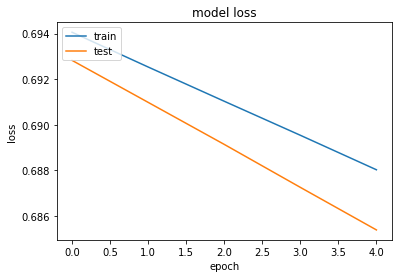

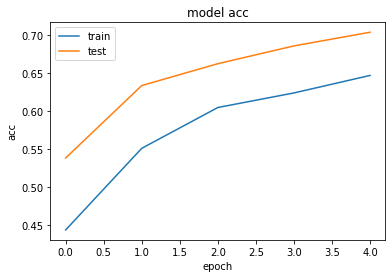

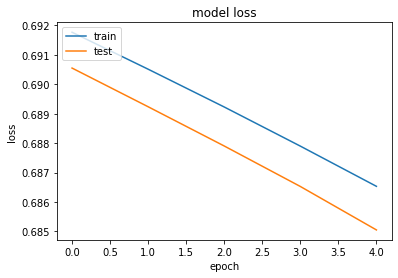

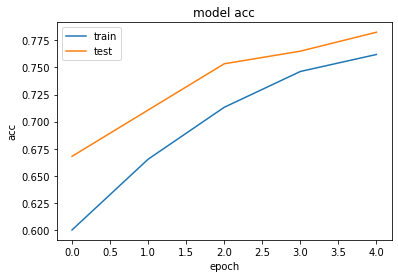

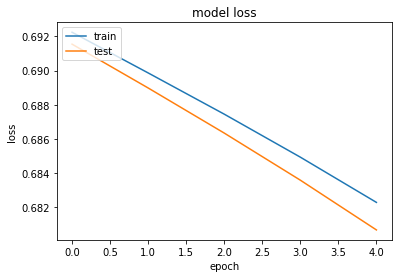

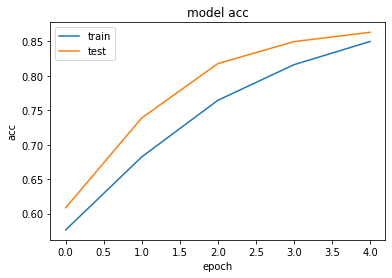

In [157]:
for l in locations[0:3]:

    plt.plot(loss[l])
    plt.plot(val_loss[l])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(acc[l])
    plt.plot(val_acc[l])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [164]:
def load_all_models(n_models):
    all_models = list()
    for i in locations[0:3]:
        # define filename for this ensemble
        filename = rf'models/model_{i}.h5'
        # load model from file
        model = keras.models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

members = load_all_models(3)

>loaded models/model_Albury.h5
>loaded models/model_BadgerysCreek.h5
>loaded models/model_Cobar.h5


In [166]:
e_train = train.copy(deep=True)
e_val = val.copy(deep=True)
e_train = format_data(e_train)
e_val = format_data(e_val)

n = len(e_train)
train_df = e_train[0:int(n*0.7)]
val_df = e_val
test_df = e_train[int(n*0.7):]

cols_to_norm = list(e_train.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
window = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [187]:
# members[0].predict(window.val_df)
# members[0].predict_classes(window.val)
window = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])
yhats = [model.predict(window.val) for model in members]
yhats = np.array(yhats)
yhats.shape

(3, 26126, 1, 1)

In [192]:
# print(yhats[0][0])
# print(yhats[0][1])
yhats_mean = np.mean(yhats, axis=0)
yhats_mean = np.mean(yhats_mean, axis=1)
yhats_mean = yhats_mean.reshape(yhats_mean.shape[0])
yhats_mean = np.array([(x>0.5).astype("int32") for x in yhats_mean])

ytrue = np.array(val_df[1:]['RainTomorrow'])
# print(ytrue.shape)

In [193]:
count = 0
val_df[1:]['RainTomorrow']
for i in range(1,yhats_mean.shape[0]):
    if ((yhats_mean[i]-ytrue[i])**2) == 0:
        count+=1
print((yhats_mean[1] - ytrue[1])^2)  
count/yhats_mean.shape[0]

2


0.7991655821786726

In [186]:
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
#         for inp in model.inputs:
#             inp._name = 'ensemble_' + str(i+1) + '_'
#             print(inp.name)
#         for out in model.outputs:
#             print(out.name)
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    print(ensemble_visible)
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    print(ensemble_outputs)
    
    merge = tf.keras.layers.concatenate(ensemble_outputs, name='merge_layer')
    hidden = tf.keras.layers.Dense(10, activation='relu', name='dense1')(merge)
    output = tf.keras.layers.Dense(3, activation='sigmoid', name='dense2')(hidden)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output, name="ensemble")
    # plot graph of ensemble
#     keras.utils.plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=lr),
        metrics=[tf.metrics.BinaryAccuracy()])
    return model

e_train = train.copy(deep=True)
e_val = val.copy(deep=True)
e_train = format_data(e_train)
e_val = format_data(e_val)

n = len(e_train)
train_df = e_train[0:int(n*0.7)]
val_df = e_train[int(n*0.7):]
test_df = e_train[int(n*0.7):]

cols_to_norm = list(e_train.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
emodel = define_stacked_model(members)
window = WindowGenerator(input_width=3, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

# trainY = train_df.pop('RainTomorrow')
    
history = emodel.fit(window.train, epochs=epochs, validation_data=window.val)

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


[<tf.Tensor 'Albury16_input_12:0' shape=(None, 7, 21) dtype=float32>, <tf.Tensor 'BadgerysCreek16_input_9:0' shape=(None, 7, 21) dtype=float32>, <tf.Tensor 'Cobar16_input_9:0' shape=(None, 7, 21) dtype=float32>]
[<tf.Tensor 'Alburydense/Sigmoid_12:0' shape=(None, 7, 1) dtype=float32>, <tf.Tensor 'BadgerysCreekdense/Sigmoid_9:0' shape=(None, 7, 1) dtype=float32>, <tf.Tensor 'Cobardense/Sigmoid_9:0' shape=(None, 7, 1) dtype=float32>]
Epoch 1/5


AssertionError: in user code:

    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /home/mqp/pyenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("dense2/Sigmoid_12:0", shape=(None, 7, 3), dtype=float32)


In [ ]:
e_train = train.copy(deep=True)
e_val = val.copy(deep=True)
e_train = format_data(e_train)
e_val = format_data(e_val)

n = len(e_train)
train_df = e_train[0:int(n*0.7)]
val_df =  e_train[int(n*0.7):]
test_df = e_train[int(n*0.7):]

cols_to_norm = list(e_train.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
# emodel = define_stacked_model(members)
window = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

In [ ]:
window.train